<a href="https://colab.research.google.com/github/fiaazwa/DeepLearning/blob/main/DaapLearning02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==================== 1. Import Necessary Libraries ====================
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# ==================== 2. Mount Google Drive ====================
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset_DeepLearning'

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Dataset_DeepLearning'
batch_size = 32
image_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 4)  # Ganti ke 4 kelas
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 37.1MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=7):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training
        model.train()
        train_loss, train_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(preds == labels.data)

        epoch_train_loss = train_loss / len(train_data)
        epoch_train_acc = train_correct.double() / len(train_data)
        train_loss_hist.append(epoch_train_loss)
        train_acc_hist.append(epoch_train_acc.item())

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(val_data)
        epoch_val_acc = val_correct.double() / len(val_data)
        val_loss_hist.append(epoch_val_loss)
        val_acc_hist.append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        scheduler.step(epoch_val_loss)

        # Simpan model terbaik
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_mobilenetv2.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_model_wts)
    return model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist


In [8]:
model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, criterion, optimizer, scheduler
)


Epoch 1/50
----------
Train Loss: 0.8921, Acc: 0.6556
Val   Loss: 0.5996, Acc: 0.7611

Epoch 2/50
----------
Train Loss: 0.4359, Acc: 0.8395
Val   Loss: 0.3933, Acc: 0.8667

Epoch 3/50
----------
Train Loss: 0.3199, Acc: 0.8798
Val   Loss: 0.3703, Acc: 0.8556

Epoch 4/50
----------
Train Loss: 0.2830, Acc: 0.8919
Val   Loss: 0.2973, Acc: 0.8667

Epoch 5/50
----------
Train Loss: 0.2926, Acc: 0.8968
Val   Loss: 0.3077, Acc: 0.8889

Epoch 6/50
----------
Train Loss: 0.2153, Acc: 0.9258
Val   Loss: 0.3211, Acc: 0.8778

Epoch 7/50
----------
Train Loss: 0.2269, Acc: 0.9177
Val   Loss: 0.3447, Acc: 0.8667

Epoch 8/50
----------
Train Loss: 0.2054, Acc: 0.9266
Val   Loss: 0.3497, Acc: 0.8667

Epoch 9/50
----------
Train Loss: 0.1717, Acc: 0.9355
Val   Loss: 0.2892, Acc: 0.8889

Epoch 10/50
----------
Train Loss: 0.1623, Acc: 0.9403
Val   Loss: 0.2803, Acc: 0.9000

Epoch 11/50
----------
Train Loss: 0.1775, Acc: 0.9387
Val   Loss: 0.2690, Acc: 0.8889

Epoch 12/50
----------
Train Loss: 0.178

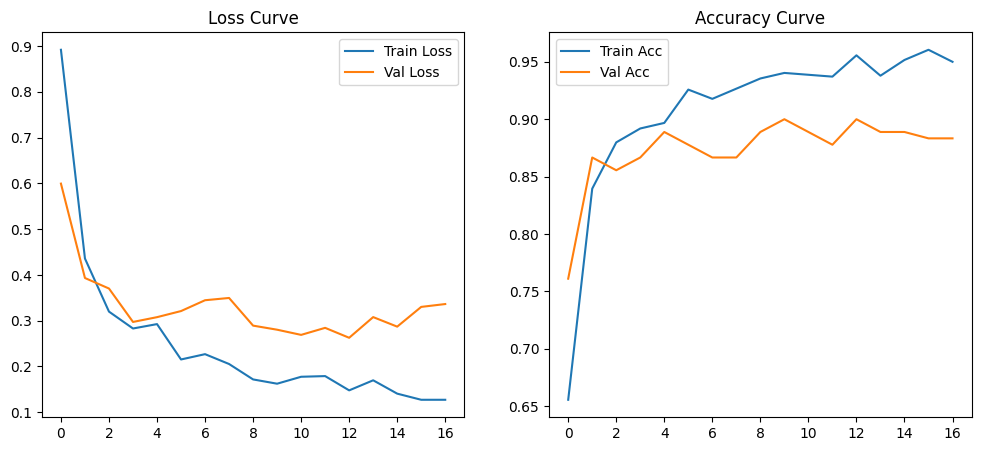

In [13]:
# Rename variables to match the names used in the plotting function
train_losses = train_loss
val_losses = val_loss
train_accuracies = train_acc
val_accuracies = val_acc

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()

              precision    recall  f1-score   support

        gaun       0.81      0.67      0.73        45
       jaket       0.89      0.73      0.80        45
        kaos       0.75      0.96      0.84        45
      kemeja       0.78      0.84      0.81        45

    accuracy                           0.80       180
   macro avg       0.81      0.80      0.80       180
weighted avg       0.81      0.80      0.80       180



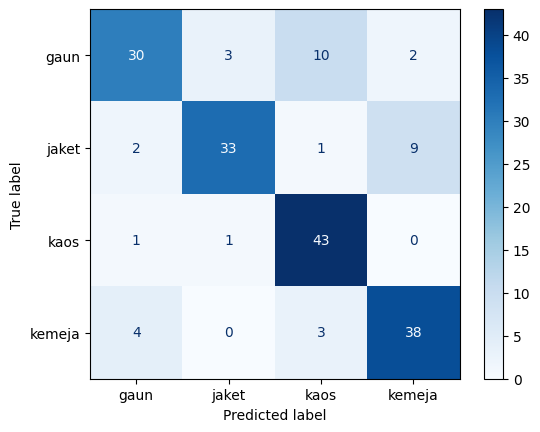

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluasi model pada data test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()


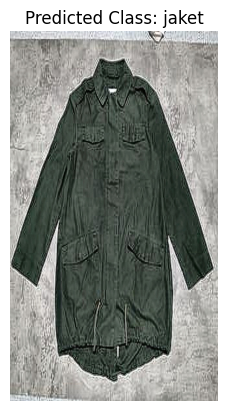

Predicted class: jaket


In [21]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(img_path, model, transform, class_names):
    # Set model ke eval mode
    model.eval()

    # Load dan transform gambar
    image = Image.open(img_path).convert("RGB")
    transformed_image = transform(image).unsqueeze(0).to(device)

    # Prediksi
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(image)
    plt.title(f"Predicted Class: {class_names[class_idx]}")
    plt.axis("off")
    plt.show()

    return class_names[class_idx]

# Contoh penggunaan
img_path = '/content/drive/MyDrive/Dataset_DeepLearning/cek/img1.jpg'  # Ganti path sesuai gambar kamu
predicted_class = predict_image(img_path, model, val_test_transform, class_names)
print(f"Predicted class: {predicted_class}")


In [20]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 577.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.6 MB/s 

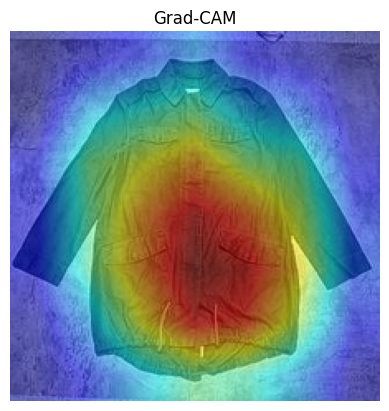

In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

import cv2
import numpy as np

# Target layer untuk MobileNetV2
target_layers = [model.features[-1]]

# Load dan siapkan gambar
img_path = '/content/drive/MyDrive/Dataset_DeepLearning/cek/img1.jpg'
image = Image.open(img_path).convert('RGB').resize((image_size, image_size))
image_np = np.array(image).astype(np.float32) / 255.0
input_tensor = val_test_transform(image).unsqueeze(0).to(device)

# Inisialisasi Grad-CAM
# Remove the 'use_cuda' argument
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(0)]  # Optional: bisa otomatis deteksi kelas juga

# Dapatkan Grad-CAM mask
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]
visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

# Tampilkan
plt.imshow(visualization)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()